# Final Project for Adaptive Decision Making
### Modeling Behavioral Data from Attention Decay Study with Single-boundary DDM
Group Members: Oscar, Emilio, and William

# Background

# Problem 

# Modeling

### Do all of our main imports first

In [1]:
%cd ..

/Users/willixl/ADM_Final


In [2]:
from __future__ import division
from ADMCode import visualize as vis

import numpy as np
import pandas as pd
import numba as nb

from numba.decorators import jit
from numpy.random import random_sample
from numba import float64, int64, vectorize, boolean

from ipywidgets import interactive
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.simplefilter('ignore', np.RankWarning)
warnings.filterwarnings("ignore", module="matplotlib")
warnings.filterwarnings("ignore")
sns.set(style='white', font_scale=1.3)

%matplotlib inline

### Create a single decision barrier DDM

In [3]:
@jit(nb.typeof((1.0, 1.0))(float64[:], float64[:], float64[:]), nopython=True)
def sim_ddm(parameters, rProb, trace):

    # extract parameters
    a, tr, v, z, si, dx, dt = parameters

    # convert drift-rate into a probability,
    # & scale by sigma (si) and timestep (dt)
    # if v > 0, then 0.5 < vProb < 1.0
    # if v < 0, then 0.0 < vProb < 0.5
    vProb = .5 * (1 + (v * np.sqrt(dt))/si)

    # define starting point with respect to boundary height
    zStart = z * a

    #initialize evidence variable at zStart
    evidence = zStart
    trace[0] = evidence

    # define deadline (max time allowed for accumulation)
    deadline = trace.size

    for nsteps in range(1, deadline):
        # sample a random probability (r) and compare w/ vProb
        if rProb[nsteps] < vProb:
            # if r < vProb, step evidence up (towards a)
            evidence += dx
        else:
            # if r > vProb, step evidence down (towards 0)
            evidence -= dx

        if evidence < zStart:
            evidence = zStart
            
        # store new value of evidence at current timestep
        trace[nsteps] = evidence
            
        if evidence >= a:
            # calculate RT (in milliseconds)
            rt = tr + (nsteps * dt)
            # set choice to 1.0 (upper bound)
            choice = 1.0

            # terminate simulation, return rt & choice
            return rt, choice

    # return -1.0 for rt and choice so we can filter out
    # trials where evidence never crossed 0 or a
    return -1.0, -1.0

### Background code for running DDM and generating dataframes

In [4]:
def gen_ddm_storage_objects(parameters, ntrials=200, deadline=1.5):
    dt = parameters[-1]
    ntime = np.int(np.floor(deadline / dt))
    data = np.zeros((ntrials, 2))
    rProb = random_sample((ntrials, ntime))
    traces = np.zeros_like(rProb)
    return data, rProb, traces

def clean_output(data, traces, deadline=1.2, stimulus=None):
    df = pd.DataFrame(data, columns=['rt', 'choice'])
    df.insert(0, 'trial', np.arange(1, 1+df.shape[0]))
    df = df[(df.rt>0)&(df.rt<deadline)]
    traces = traces[df.index.values, :]
    df = df.reset_index(drop=True)
    return df, traces

@jit((float64[:], float64[:,:], float64[:,:], float64[:,:]), nopython=True)
def _sim_ddm_trials_(parameters, data, rProb, traces):
    ntrials = data.shape[0]
    for t in range(ntrials):
        data[t, :] = sim_ddm(parameters, rProb[t], traces[t])

def sim_ddm_trials(parameters, ntrials=500, deadline=1.5, decay=False):
    data, rProb, traces = gen_ddm_storage_objects(parameters, ntrials, deadline)
    _sim_ddm_trials_(parameters, data, rProb, traces)
    df, traces = clean_output(data, traces, deadline=deadline)
    return df, traces

### Initialize our parameters
We can begin with a regular DDM (with one boundary) and tweak with the parameters or potentially add more parameters to get this best fit to the behavioral data that we have

In [5]:
a = .09 # boundary height
v = .25 # strong drift-rate
tr = .15 # nondecision time (in seconds)
z = 0 # starting point ([0,1], fraction of a)

dt = .001 # time step
si = .1 # sigma (noise scalar)
dx = si * np.sqrt(dt) # evidence step
deadline = 2 # max decision time
ntime = np.int(np.floor(deadline / dt)) # time limit for decision
ntrials = 100 # number of trials to simulate



parameters = np.array([a, tr, v, z, si, dx, dt])

In [6]:
df, traces = sim_ddm_trials(parameters, ntrials, deadline)
df.head(10)

,trial,rt,choice
0,1,0.944,1.0
1,2,0.572,1.0
2,3,0.344,1.0
3,4,0.343,1.0
4,5,0.485,1.0
5,6,0.571,1.0
6,7,0.395,1.0
7,8,0.551,1.0
8,9,0.928,1.0
9,10,0.498,1.0


In [7]:
accuracy = df.choice.mean()
corRT = df[df.choice==1].rt.mean()
y,x = df.shape
count = 0 
print(y)


while count <y:

    df["rt"][count] =  (df["rt"][count])
    
    count+=1


print("RT (cor) = {:.0f} ms".format(corRT/dt))
print("Accuracy = {:.0f}%".format(accuracy*100))

100
RT (cor) = 449 ms
Accuracy = 100%


### Visualization of single barrier DDM

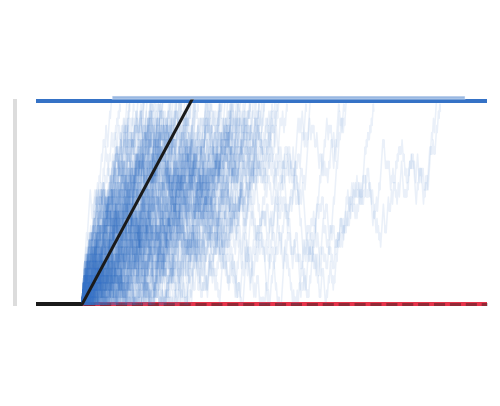

In [8]:
ax = vis.plot_this_sims(df, parameters,traces = traces, plot_v=True)

### Create a single decision barrier DDM with attention decay

In [9]:
@jit(nb.typeof((1.0, 1.0))(float64[:], float64[:], float64[:]), nopython=True)
def sim_decay_ddm(parameters, rProb, trace):
    # extract parameters
    a, tr, v, z, si, dx, dt, decay, decay_acceleration = parameters

    # convert drift-rate into a probability,
    # & scale by sigma (si) and timestep (dt)
    # if v > 0, then 0.5 < vProb < 1.0
    # if v < 0, then 0.0 < vProb < 0.5
    vProb = .5 * (1 + (v * np.sqrt(dt))/si)

    # define starting point with respect to boundary height
    zStart = z * a

    #initialize evidence variable at zStart
    evidence = zStart
    trace[0] = evidence

    # define deadline (max time allowed for accumulation)
    deadline = trace.size

    for nsteps in range(1, deadline):
        # sample a random probability (r) and compare w/ vProb
        if rProb[nsteps] < vProb:
            # if r < vProb, step evidence up (towards a)
            evidence += dx
        else:
            # if r > vProb, step evidence down (towards 0)
            evidence -= dx

        # always add in decay parameter
        evidence -= decay
            
        if evidence < zStart:
            evidence = zStart
            
        # store new value of evidence at current timestep
        trace[nsteps] = evidence
            
        if evidence >= a:
            # calculate RT (in milliseconds)
            rt = tr + (nsteps * dt)
            # set choice to 1.0 (upper bound)
            choice = 1.0

            # terminate simulation, return rt & choice
            return rt, choice

    # return -1.0 for rt and choice so we can filter out
    # trials where evidence never crossed 0 or a
    return -1.0, -1.0

In [10]:
df.head(10)

,trial,rt,choice
0,1,0.944,1.0
1,2,0.572,1.0
2,3,0.344,1.0
3,4,0.343,1.0
4,5,0.485,1.0
5,6,0.571,1.0
6,7,0.395,1.0
7,8,0.551,1.0
8,9,0.928,1.0
9,10,0.498,1.0


### Background code for running decay DDM and generating dataframes

In [11]:
@jit((float64[:], float64[:,:], float64[:,:], float64[:,:]), nopython=True)
def _sim_decay_ddm_trials_(parameters, data, rProb, traces):
    ntrials = data.shape[0]
    for t in range(ntrials):
        a, tr, v, z, si, dx, dt, decay, decay_acceleration = parameters
        decay += decay_acceleration
        parameters_decay = np.array([a, tr, v, z, si, dx, dt, decay, decay_acceleration])
        data[t, :] = sim_decay_ddm(parameters, rProb[t], traces[t])

def sim_decay_ddm_trials(parameters, ntrials=500, deadline=1.5, decay=False):
    data, rProb, traces = gen_ddm_storage_objects(parameters, ntrials, deadline)
    _sim_decay_ddm_trials_(parameters, data, rProb, traces)
    df, traces = clean_output(data, traces, deadline=deadline)
    return df, traces

In [12]:
a = .3 # boundary height
v = .40 # strong drift-rate
tr = 0 # nondecision time (in seconds)
z = 0 # starting point ([0,1], fraction of a)

dt = .001 # time step
si = .1 # sigma (noise scalar)
dx = si * np.sqrt(dt) # evidence step
deadline = 5 # max decision time
ntime = np.int(np.floor(deadline / dt)) # time limit for decision
ntrials = 1000 # number of trials to simulate
decay = 0.000005
decay_acceleration = 0.00001


parameters_decay = np.array([a, tr, v, z, si, dx, dt, decay, decay_acceleration])


In [13]:
decayDf, traces = sim_decay_ddm_trials(parameters_decay, ntrials, deadline)
meanRT = decayDf.rt.mean()

stdDevRT = decayDf.rt.std()

print("RT (average) = {:.0f} ms".format(meanRT/dt))
print('stdDev = {:.0f} ms'.format(stdDevRT/dt))

RT (average) = 723 ms
stdDev = 215 ms


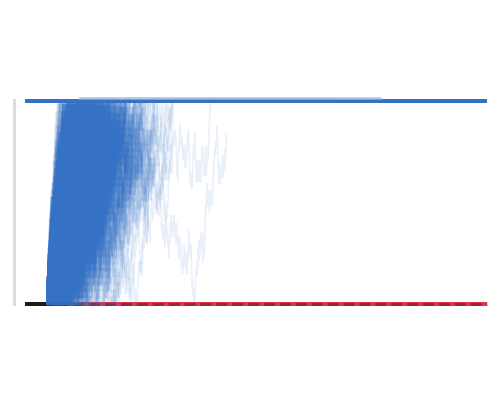

In [14]:
bx = vis.plot_this_sims(decayDf, parameters,traces = traces, plot_v=False)

## Our Approach to Model Accuracy Estimation 
Now that we've created a single boundary DDM capable of producing simulated Reaction Time distribution, we want to begin manipulating its parameters to fit it to our experimental data. In order to do that in a principled way, however, we need a way of measuring if a particular set of parameters produces a better fit on the experimental data than another set of parameters. For this we will use a Chi Square 'goodness of fit' test. 

#### TODO: $$Formula For Chi Square Goes Here$$ 

The goal for our model is to minimize the value of the Chi Square, as it represents the likelihood that the distribution produced by the model is the same distribution from the experimental data.

### Chi Square to Calculate Goodnes of Fit
At a conceptual level, we are comparing how closely the observed (experimental) data matches the expected (simulation) data. We calculate the probability of any differences between the datasets being present, if they are indeed sampled from the same distribution. 

#### TODO: Visualization of Observed vs Expected distribution, can use lecture slides



+ **Note** here, that because we are using a single output of the model simulation, a model that inherently has a high variance between Simualtion instances can have significantly different $\chi^2 $ value depending on which instance we use calculate this statistic. As such, averaging the distributions between simulations of such a model increases reliability. 

### 'Bucketing' the data
For us to be able to calculate the $\chi^2$ fit we need to choose RT intervals within which to 'bucket' data points. Intuitively, the more fine-grained the buckets, the snugger the fit. But there is a catch. For this calculation to have statistical validity we must have at least 5 data points within each bucket. While this is not a problem for simulation data, it is a limitation for our experimental data since we only have so many trials. 

This is a key constraint that has downstream effects on what we choose to model and what comparisons we draw. Particularly, individual subject modeling now becomes a challnge, as we only have 47 data points for the entire experiment (3 for the pre-test period, 41 for the experimental period, and 3 for the post-test period). This is mostly due to flaws in the experimental design, and of course, the researchers have no clue that the data was going to be modeled in this way. 

#### TODO: Present our RT intervals and the rationale/process for arriving at them 



### The algorithm for calculating the goodness of fit
Special thanks to Wikipedia, Khan Academy and Tim and Kyle for the surprinsingly informative vizualization of the $\chi^2$ estimation on the DDM lecture slides. 

1. Define the buckets for your RT intervals. 
2. Collect your data points into the buckets. Do this for the experimental data and the simulated data (using the same intervals for both data sets).  
3. Count the Data points inside the intervals to make sure there is more than 5 in each bucket (Large Counts condition)
4. For each interval calculate $(observed counts - expected counts)/expected counts$, and then sum them all to calculate the Chi Square of your model. 
$$ \chi^s = SumFormulaHere $$
5. Get the degrees of freedom of this Chi Square distribution by subtracting one from your number of buckets. 
6. Compare your Chi Square against the critical Chi Square values for different values of $\alpha$. They represent the likelihood that your simulated and observed data come from the same distribution. 
    * There is a $\alpha$ percent chance that if the two datasets come from the same distribution, their differences would be what they are or more extreme



## Setting up goodness of fit calculation

### Importing and Formatting experimental data

In [15]:
import pandas as pd
dataPath = "data/RTData.csv"
data = pd.read_csv(dataPath, header = 0)
data = data.dropna()

dataWhole = data[data.isFreq == 1]
dataisV = dataWhole[dataWhole.isVar==1]
dataisNV = dataWhole[dataWhole.isVar==0]
def changeD(rData): 
    rRT = "clickDelay"
    rt = "rt"
    trial = []
    newRT = []
    newCh = []
    dShape,garb = rData.shape
    trial = [i for i in range(dShape)]
    newRT = list(rData[rRT])

    newCh = [1 for i in range(dShape)]
    newDf = {"trial":trial,"rt":newRT,"choice":newCh}
    return pd.DataFrame(data = newDf)
dataAll,dataVar,dataNVar = changeD(dataWhole),changeD(dataisV),changeD(dataisNV)

#add identifiers 
dataAll['id'] = 'All'
dataVar['id'] = 'Var'
dataNVar['id'] = 'NVar'

### Defining the Buckets
Our first thought to define our 'buckets' was by setting them to be the width of one standard deviation, with two 'catch all' buckets for the distribution tails. After some testing, these proved to be a bit too wide so we set them to half of a standard deviation. 

We experimented by using the standard error $\sigma/\sqrt{N}$, but it proved too small. 

After gathering the RT counts within the buckets we realized we had to collapse the initial buckets into one because the contained too few counts. As such they would violate the large counts assumption of the Chi Square model and ruin our **statistical validity**. This is due to the experimental data having a rightward skew. 

#### Our initial buckets
Experimental buckets:
+ All data buckets =  [0, 0, 0, 16, 108, 70, 69, 44, 27, 20, 15, 16, 31]
+ Variable condition buckets =  [0, 0, 0, 22, 54, 33, 31, 30, 14, 9, 12, 8, 20]
+ Sable condition buckets =  [0, 0, 0, 2, 47, 43, 30, 18, 10, 8, 3, 6, 16]

We need at least 5 data points in each bucket. 

In [16]:
import math

def stdDev(mean,L):
    Sum = 0
    for i in L: 
        Sum+=math.pow((i-mean),2)
    return math.sqrt((Sum/len(L)))


def bucketer(mean,stdD,n):
    conMax = 3 #confidence rating 
    n = math.sqrt(n)
    bucket = []
    low = -1*conMax
    high = conMax+1 
    for i in [j for j in range(low,high)]:
        term = mean + i*(stdD/n)
        bucket.append(term)
    return bucket

def sampleBasedBucketer(mean, stdD):
    distance = 6 # 2 std devs, since it will be halved below
    bounds = []
    for i in range(-distance, distance):
        term = mean + i * (stdD/3)
        bounds.append(term)    
    return bounds


def getSampleBounds(panDf):
    mean = panDf.rt.mean()
    stdDev = panDf.rt.std()
    print("sample Mean = {:.3f} s".format(mean))
    print("sample Std Dev = {:.3f} s".format(stdDev))
    return sampleBasedBucketer(mean, stdDev)
           
def getStats(panDf): 
    y,x = panDf.shape
    Sum = 0
    count =0
    new = []
    while count<y:
        ind = panDf["rt"][count]
        Sum+= ind
        new+=[ind]
        count+=1
    mean = Sum/count
    std = stdDev(mean,new)
    n = len(new)
    buck = bucketer(mean,std,n)
    return mean,std,buck

testM,testD,testB = getStats(decayDf)

sampleBounds = getSampleBounds(decayDf)

print('std Error buckets')
for bound in testB:
    print(bound)

print('sample std Dev buckets')
for bound in sampleBounds:
    print(bound)

print('sample std Dev buckets')
for bound in sampleBounds:
    print(bound)
    
print("simulated Mean = {:.3f} s".format(testM))
print("simulated Std Dev = {:.3f} s".format(testD))

sample Mean = 0.723 s
sample Std Dev = 0.215 s
std Error buckets
0.7029320296082563
0.7097320197388374
0.7165320098694185
0.7233319999999995
0.7301319901305806
0.7369319802611617
0.7437319703917428
sample std Dev buckets
0.29304766643472635
0.3647617220289386
0.4364757776231509
0.5081898332173631
0.5799038888115754
0.6516179444057877
0.723332
0.7950460555942123
0.8667601111884246
0.9384741667826368
1.010188222376849
1.0819022779710614
sample std Dev buckets
0.29304766643472635
0.3647617220289386
0.4364757776231509
0.5081898332173631
0.5799038888115754
0.6516179444057877
0.723332
0.7950460555942123
0.8667601111884246
0.9384741667826368
1.010188222376849
1.0819022779710614
simulated Mean = 0.723 s
simulated Std Dev = 0.215 s


#### Count the buckets into an histogram-like array.

In [17]:
def isInBounds(lower, upper, value):
    return lower <= value and value <= upper

def getBuckets(bounds, dataframe):
    buckets = [0] * (len(bounds) + 1) 
    bounds.sort()
    boundsList = [] # [(lower1, upper1), (lower2, upper2) ...]
    for i,bound in enumerate(bounds):
        if i == 0:
            boundsList.append((0, bound))
        else:
            boundsList.append((bounds[i-1], bound))
        #add right tail end bucket
        if i == len(bounds) - 1:
            boundsList.append((bound, 100)) #100 is a catchAll 
            
    #print(dataframe.shape)
    for i,(lower, upper) in enumerate(boundsList):
        for rt in dataframe.rt.values:
            if isInBounds(lower, upper, rt):
                buckets[i] += 1
    return buckets

obsvMean,obsvDev,obsvBuck = getStats(dataAll)

sampleObsvBuck = getSampleBounds(dataAll)

simBucketCount = getBuckets(testB, decayDf)
obsvBucketCount = getBuckets(obsvBuck, dataAll)
obsvSampleBucketCount = getBuckets(sampleObsvBuck, dataAll)
simSampleBucketCount = getBuckets(sampleBounds, decayDf)



print("simulated buckets: \n", simBucketCount)
print("simulated buckets sample based: \n", simSampleBucketCount)


print("\n All data experimental buckets: \n", obsvBucketCount)
print("All experimental  buckets sample based: \n", obsvSampleBucketCount)

#using sample based from now on

print("\nExperimental buckets:")
allDataBuckets = getBuckets(getSampleBounds(dataAll), dataAll)
varDataBuckets = getBuckets(getSampleBounds(dataVar), dataVar)
staDataBuckets = getBuckets(getSampleBounds(dataNVar), dataNVar)
print("All data buckets = ", allDataBuckets)
print("Variable condition buckets = ", getBuckets(getSampleBounds(dataVar), dataVar))
print("Sable condition buckets = ", getBuckets(getSampleBounds(dataNVar), dataNVar))

sample Mean = 3.026 s
sample Std Dev = 2.304 s
simulated buckets: 
 [530, 15, 10, 13, 10, 8, 9, 405]
simulated buckets sample based: 
 [2, 4, 45, 99, 120, 144, 154, 106, 109, 71, 47, 38, 61]

 All data experimental buckets: 
 [238, 7, 10, 8, 9, 11, 6, 127]
All experimental  buckets sample based: 
 [0, 0, 0, 16, 108, 70, 69, 44, 27, 20, 15, 16, 31]

Experimental buckets:
sample Mean = 3.026 s
sample Std Dev = 2.304 s
sample Mean = 2.890 s
sample Std Dev = 2.096 s
sample Mean = 3.200 s
sample Std Dev = 2.540 s
All data buckets =  [0, 0, 0, 16, 108, 70, 69, 44, 27, 20, 15, 16, 31]
sample Mean = 2.890 s
sample Std Dev = 2.096 s
Variable condition buckets =  [0, 0, 0, 22, 54, 33, 31, 30, 14, 9, 12, 8, 20]
sample Mean = 3.200 s
sample Std Dev = 2.540 s
Sable condition buckets =  [0, 0, 0, 2, 47, 43, 30, 18, 10, 8, 3, 6, 16]


#### Calculate Chi Square
while making sure to not violete the Large Counts rule

In [18]:
## calculate Chi squares
import scipy
from scipy import stats

def collapseUpToFive(L):
    firstCount = L[0]
    i = 1
    while firstCount <= 5:
        firstCount += L[i]
        i += 1
    return i - 1

#print(collapseUpToFive([0, 0, 0, 22, 54, 33, 31, 30, 14, 9, 12, 8, 20]))
#print(collapseUpToFive([0, 0, 0, 2, 47, 43, 30, 18, 10, 8, 3, 6, 16]))


def getChiSquare(observedDf, expectedDf):
    #get ObservedBounds
    bounds = getSampleBounds(observedDf)
    # get buckets for both using observedBounds
    observedBuckets = getBuckets(bounds, observedDf)
    truncator = collapseUpToFive(observedBuckets)
    adjustedBounds = bounds[truncator:]
    observedBuckets = getBuckets(adjustedBounds, observedDf)
    expectedBuckets = getBuckets(adjustedBounds, expectedDf)
    
    assert(len(observedBuckets) == len(expectedBuckets))
    
    
    
    observed_values = scipy.array(observedBuckets)
    expected_values = scipy.array(expectedBuckets)
    chiSquare, pValue = scipy.stats.chisquare(observed_values, f_exp=expected_values)
    print("observed buckets =", observedBuckets)
    print("expected buckets = ", expectedBuckets)
    print("chi Square = {:3f}".format(chiSquare))
    print("pvalue = {:3f}".format(pValue))
    return chiSquare, pValue 

#test chi square:
getChiSquare(dataVar, dataVar) 




sample Mean = 2.890 s
sample Std Dev = 2.096 s
observed buckets = [22, 54, 33, 31, 30, 14, 9, 12, 8, 20]
expected buckets =  [22, 54, 33, 31, 30, 14, 9, 12, 8, 20]
chi Square = 0.000000
pvalue = 1.000000


(0.0, 1.0)

### Vizualize the data to build intuition

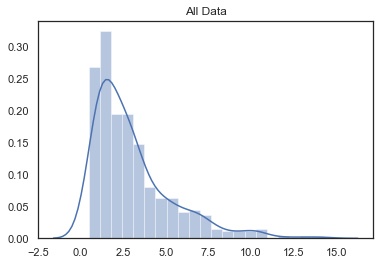

In [19]:
#plotting the raw Data 
allDataAx = sns.distplot(dataAll.rt.values).set_title('All Data')

#sample Mean = 3.026 s
#sample Std Dev = 2.304 s
#adj bounds =  [0.7220, 1.4900, 2.2581, 3.02624, 3.7943, 4.5623, 5.330, 6.09854, 6.8666]

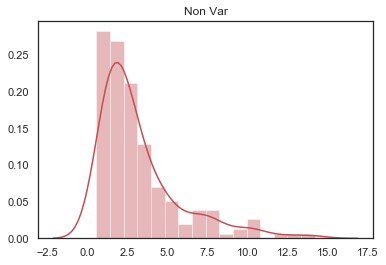

In [20]:
# Non Variable Statistics
#sample Mean = 3.200 s
#sample Std Dev = 2.540 s
#adj bounds (sec) = , 1.507, 2.354, 3.200, 4.047, 4.893, 5.740, 6.586, 7.433

staDataAx = sns.distplot(dataNVar.rt.values, color='r').set_title('Non Var')

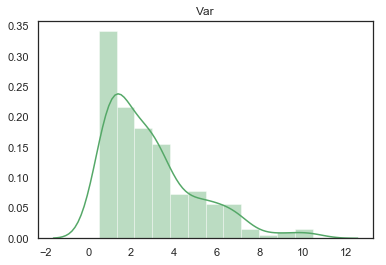

In [21]:
# Variable Statistics
#sample Mean = 2.890 s
#sample Std Dev = 2.096 s
#adj bounds (sec) =  0.793, 1.492, 2.191, 2.890, 3.588, 4.287, 4.986, 5.685, 6.384

varDataAx = sns.distplot(dataVar.rt.values, color='g').set_title('Var')

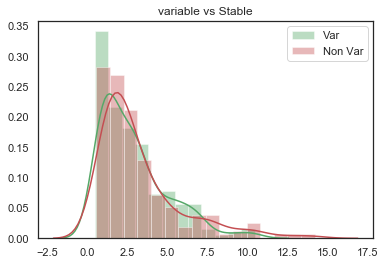

In [22]:
#plotting the raw Data for var and sta
varDataAx = sns.distplot(dataVar.rt.values, color='g', label='Var')
staDataAx = sns.distplot(dataNVar.rt.values, color='r', label='Non Var')
legend, title = plt.legend(), plt.title('variable vs Stable')

## Parameter Estimation

#### Simple Single-Bound DDM - Variable

sample Mean = 2.890 s
sample Std Dev = 2.096 s
observed buckets = [22, 54, 33, 31, 30, 14, 9, 12, 8, 20]
expected buckets =  [19, 67, 47, 25, 22, 15, 10, 13, 6, 8]
chi Square = 30.425632
pvalue = 0.000371
RT (average) = 2464 ms
stdDev = 1708 ms
sample Mean = 2.890 s
sample Std Dev = 2.096 s
observed buckets = [22, 54, 33, 31, 30, 14, 9, 12, 8, 20]
expected buckets =  [15, 57, 43, 23, 28, 17, 18, 7, 5, 17]
chi Square = 19.605861
pvalue = 0.020507

RT (average) = 2800 ms
stdDev = 1915 ms
sample Mean = 2.890 s
sample Std Dev = 2.096 s
observed buckets = [22, 54, 33, 31, 30, 14, 9, 12, 8, 20]
expected buckets =  [16, 55, 49, 32, 20, 21, 12, 8, 5, 11]
chi Square = 26.770891
pvalue = 0.001526

RT (average) = 2610 ms
stdDev = 1747 ms
sample Mean = 2.890 s
sample Std Dev = 2.096 s
observed buckets = [22, 54, 33, 31, 30, 14, 9, 12, 8, 20]
expected buckets =  [12, 66, 50, 27, 22, 14, 14, 12, 2, 11]
chi Square = 46.946186
pvalue = 0.000000

RT (average) = 2558 ms
stdDev = 1739 ms
sample Mean = 2.

sample Mean = 2.890 s
sample Std Dev = 2.096 s
observed buckets = [22, 54, 33, 31, 30, 14, 9, 12, 8, 20]
expected buckets =  [20, 50, 32, 37, 24, 21, 19, 5, 9, 13]
chi Square = 24.301056
pvalue = 0.003850

RT (average) = 2836 ms
stdDev = 1889 ms
sample Mean = 2.890 s
sample Std Dev = 2.096 s
observed buckets = [22, 54, 33, 31, 30, 14, 9, 12, 8, 20]
expected buckets =  [15, 56, 44, 32, 21, 17, 11, 15, 8, 10]
chi Square = 21.469536
pvalue = 0.010721

RT (average) = 2747 ms
stdDev = 1885 ms
sample Mean = 2.890 s
sample Std Dev = 2.096 s
observed buckets = [22, 54, 33, 31, 30, 14, 9, 12, 8, 20]
expected buckets =  [14, 56, 48, 29, 21, 22, 10, 8, 9, 13]
chi Square = 22.214864
pvalue = 0.008222

RT (average) = 2744 ms
stdDev = 1871 ms
sample Mean = 2.890 s
sample Std Dev = 2.096 s
observed buckets = [22, 54, 33, 31, 30, 14, 9, 12, 8, 20]
expected buckets =  [19, 47, 53, 31, 27, 15, 6, 7, 9, 17]
chi Square = 15.175359
pvalue = 0.086230

RT (average) = 2740 ms
stdDev = 1944 ms
sample Mean = 2.

sample Mean = 2.890 s
sample Std Dev = 2.096 s
observed buckets = [22, 54, 33, 31, 30, 14, 9, 12, 8, 20]
expected buckets =  [20, 51, 51, 28, 21, 11, 18, 14, 5, 13]
chi Square = 22.081110
pvalue = 0.008625

RT (average) = 2724 ms
stdDev = 1910 ms
sample Mean = 2.890 s
sample Std Dev = 2.096 s
observed buckets = [22, 54, 33, 31, 30, 14, 9, 12, 8, 20]
expected buckets =  [23, 57, 41, 21, 27, 21, 12, 12, 6, 9]
chi Square = 24.052031
pvalue = 0.004220

RT (average) = 2659 ms
stdDev = 1874 ms
sample Mean = 2.890 s
sample Std Dev = 2.096 s
observed buckets = [22, 54, 33, 31, 30, 14, 9, 12, 8, 20]
expected buckets =  [18, 58, 36, 37, 20, 21, 9, 10, 12, 10]
chi Square = 21.454391
pvalue = 0.010779

RT (average) = 2748 ms
stdDev = 1924 ms
sample Mean = 2.890 s
sample Std Dev = 2.096 s
observed buckets = [22, 54, 33, 31, 30, 14, 9, 12, 8, 20]
expected buckets =  [17, 60, 51, 23, 18, 20, 18, 9, 5, 9]
chi Square = 41.750583
pvalue = 0.000004

RT (average) = 2599 ms
stdDev = 1770 ms
sample Mean = 2

sample Mean = 2.890 s
sample Std Dev = 2.096 s
observed buckets = [22, 54, 33, 31, 30, 14, 9, 12, 8, 20]
expected buckets =  [12, 55, 51, 34, 18, 20, 12, 12, 3, 15]
chi Square = 35.519162
pvalue = 0.000048

RT (average) = 2735 ms
stdDev = 1894 ms
sample Mean = 2.890 s
sample Std Dev = 2.096 s
observed buckets = [22, 54, 33, 31, 30, 14, 9, 12, 8, 20]
expected buckets =  [17, 61, 43, 31, 27, 11, 8, 7, 7, 15]
chi Square = 11.256916
pvalue = 0.258509

RT (average) = 2672 ms
stdDev = 2012 ms
sample Mean = 2.890 s
sample Std Dev = 2.096 s
observed buckets = [22, 54, 33, 31, 30, 14, 9, 12, 8, 20]
expected buckets =  [19, 49, 53, 27, 23, 22, 14, 11, 6, 9]
chi Square = 30.150911
pvalue = 0.000414

RT (average) = 2663 ms
stdDev = 1675 ms
sample Mean = 2.890 s
sample Std Dev = 2.096 s
observed buckets = [22, 54, 33, 31, 30, 14, 9, 12, 8, 20]
expected buckets =  [16, 51, 48, 32, 25, 15, 14, 7, 6, 16]
chi Square = 15.235697
pvalue = 0.084662

RT (average) = 2785 ms
stdDev = 1891 ms
sample Mean = 2.

sample Mean = 2.890 s
sample Std Dev = 2.096 s
observed buckets = [22, 54, 33, 31, 30, 14, 9, 12, 8, 20]
expected buckets =  [15, 58, 40, 34, 29, 14, 11, 7, 12, 11]
chi Square = 17.698752
pvalue = 0.038834

RT (average) = 2701 ms
stdDev = 1778 ms
sample Mean = 2.890 s
sample Std Dev = 2.096 s
observed buckets = [22, 54, 33, 31, 30, 14, 9, 12, 8, 20]
expected buckets =  [20, 58, 49, 25, 18, 13, 15, 14, 6, 13]
chi Square = 22.338887
pvalue = 0.007865

RT (average) = 2694 ms
stdDev = 1927 ms
sample Mean = 2.890 s
sample Std Dev = 2.096 s
observed buckets = [22, 54, 33, 31, 30, 14, 9, 12, 8, 20]
expected buckets =  [23, 53, 50, 29, 24, 15, 14, 6, 6, 12]
chi Square = 21.332658
pvalue = 0.011253

RT (average) = 2594 ms
stdDev = 1807 ms
sample Mean = 2.890 s
sample Std Dev = 2.096 s
observed buckets = [22, 54, 33, 31, 30, 14, 9, 12, 8, 20]
expected buckets =  [25, 47, 49, 28, 20, 19, 18, 7, 4, 13]
chi Square = 29.104920
pvalue = 0.000622

RT (average) = 2675 ms
stdDev = 1856 ms
sample Mean = 

IndexError: single positional indexer is out-of-bounds

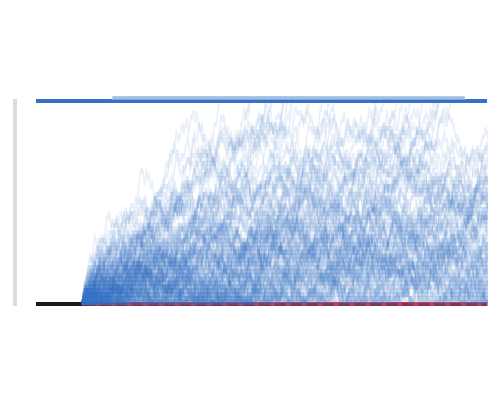

In [23]:
a = .5 # boundary height
v = .0235 # strong drift-rate
tr = .15 # nondecision time (in seconds)
z = 0 # starting point ([0,1], fraction of a)

dt = .001 # time step
si = .3 # sigma (noise scalar)
dx = si * np.sqrt(dt) # evidence step
deadline = 10 # max decision time
ntime = np.int(np.floor(deadline / dt)) # time limit for decision
ntrials = 233 # number of trials to simulate



parameters = np.array([a, tr, v, z, si, dx, dt])

simVarDf, traces = sim_ddm_trials(parameters, ntrials, deadline)
cs, p = getChiSquare(dataVar, simVarDf)

while p < 0.7:
    meanRT = simVarDf.rt.mean()
    stdDevRT = simVarDf.rt.std()

    print("RT (average) = {:.0f} ms".format(meanRT/dt))
    print('stdDev = {:.0f} ms'.format(stdDevRT/dt))
    simVarDf, traces = sim_ddm_trials(parameters, ntrials, deadline)
    cs,p = getChiSquare(dataVar, simVarDf)
    print()

varx = vis.plot_this_sims(df, parameters,traces = traces, plot_v=True)

In [ ]:
a = .5 # boundary height
v = .0235 # strong drift-rate
tr = .15 # nondecision time (in seconds)
z = 0 # starting point ([0,1], fraction of a)

dt = .001 # time step
si = .3 # sigma (noise scalar)
dx = si * np.sqrt(dt) # evidence step
deadline = 10 # max decision time
ntime = np.int(np.floor(deadline / dt)) # time limit for decision
ntrials = 233 # number of trials to simulate
decay = 0.000005
decay_acceleration = 0.00001


parameters_decay = np.array([a, tr, v, z, si, dx, dt, decay, decay_acceleration])

simDecayVarDf, traces = sim_decay_ddm_trials(parameters_decay, ntrials, deadline)
cs, p = getChiSquare(dataVar, simDecayVarDf)

while p < 0.1:
    meanRT = simDecayVarDf.rt.mean()
    stdDevRT = simDecayVarDf.rt.std()

    print("RT (average) = {:.0f} ms".format(meanRT/dt))
    print('stdDev = {:.0f} ms'.format(stdDevRT/dt))
    simDecayVarDf, traces = sim_decay_ddm_trials(parameters_decay, ntrials, deadline)
    cs,p = getChiSquare(dataVar, simDecayVarDf)
    print()

varx = vis.plot_this_sims(df, parameters,traces = traces, plot_v=True)

# TODO

+ Estimate parameters for models (show before and after to show improvement in chi squares)
    + write function that automatically calculates the chi squared against a defined experimental data set (all, var, Nvar)
    + MVP (DDM for Var vs Nvar)
+ Beyond 1: QQ plots (prolly not lol)
+ Results section
+ Conclusion 
+ Write Background and Problem sections

# Results

# Conclusion